In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


Using TensorFlow backend.
/Users/chandu/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
#importing data files for all the months separately
#POWER
path=r"/Users/chandu/Desktop/IOT DATATHON/Chiller"
df_p_c1=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_1/P/*.csv")]
df_p_c2=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_2/P/*.csv")]
df_p_c3=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_3/P/*.csv")]
df_p_c4=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_4/P/*.csv")]

#TEMP
df_t_c1=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_1/T/*.csv")]
df_t_c2=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_2/T/*.csv")]
df_t_c3=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_3/T/*.csv")]
df_t_c4=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_4/T/*.csv")]

#EVAPORATOR
df_e_c1=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_1/E/*.csv")]
df_e_c2=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_2/E/*.csv")]
df_e_c3=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_3/E/*.csv")]
df_e_c4=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_4/E/*.csv")]

#CONDENSER
df_c_c1=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_1/C/*.csv")]
df_c_c2=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_2/C/*.csv")]
df_c_c3=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_3/C/*.csv")]
df_c_c4=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Chiller_4/C/*.csv")]

#TEMPERATURE
df_temp=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Weather/Temp/*.csv")]

#HUMID
df_humid=[pd.read_csv(file,index_col="ts") for file in glob.glob(path+ "/Weather/Humid/*.csv")]

In [4]:
#concatenating the dataframes and subsetting the columns
#POWER
tab_p_c1=pd.concat(df_p_c1).sort_index()
tab_p_c2=pd.concat(df_p_c2).sort_index()
tab_p_c3=pd.concat(df_p_c3).sort_index()
tab_p_c4=pd.concat(df_p_c4).sort_index()

tab_p_c1=tab_p_c1[["ch1Watt","ch2Watt","ch3Watt","totalPositiveWattHour"]]
tab_p_c2=tab_p_c2[["ch1Watt","ch2Watt","ch3Watt","totalPositiveWattHour"]]
tab_p_c3=tab_p_c3[["ch1Watt","ch2Watt","ch3Watt","totalPositiveWattHour"]]
tab_p_c4=tab_p_c4[["ch1Watt","ch2Watt","ch3Watt","totalPositiveWattHour"]]

#TEMP
tab_t_c1=pd.concat(df_t_c1).sort_index()
tab_t_c2=pd.concat(df_t_c2).sort_index()
tab_t_c3=pd.concat(df_t_c3).sort_index()
tab_t_c4=pd.concat(df_t_c4).sort_index()

tab_t_c1=tab_t_c1[["value1","value2","value3","value4"]]
tab_t_c2=tab_t_c2[["value1","value2","value3","value4"]]
tab_t_c3=tab_t_c3[["value1","value2","value3","value4"]]
tab_t_c4=tab_t_c4[["value1","value2","value3","value4"]]

tab_t_c1.columns=["temp1","temp2","temp3","temp4"]
tab_t_c2.columns=["temp1","temp2","temp3","temp4"]
tab_t_c3.columns=["temp1","temp2","temp3","temp4"]
tab_t_c4.columns=["temp1","temp2","temp3","temp4"]

#EVAPORATOR
tab_e_c1=pd.concat(df_e_c1).sort_index()
tab_e_c2=pd.concat(df_e_c2).sort_index()
tab_e_c3=pd.concat(df_e_c3).sort_index()
tab_e_c4=pd.concat(df_e_c4).sort_index()

tab_e_c1=tab_e_c1[["flowRate"]]
tab_e_c2=tab_e_c2[["flowRate"]]
tab_e_c3=tab_e_c3[["flowRate"]]
tab_e_c4=tab_e_c4[["flowRate"]]

tab_e_c1.columns=["e.flowRate"]
tab_e_c2.columns=["e.flowRate"]
tab_e_c3.columns=["e.flowRate"]
tab_e_c4.columns=["e.flowRate"]

#CONDENSER
tab_c_c1=pd.concat(df_c_c1).sort_index()
tab_c_c2=pd.concat(df_c_c2).sort_index()
tab_c_c3=pd.concat(df_c_c3).sort_index()
tab_c_c4=pd.concat(df_c_c4).sort_index()

tab_c_c1=tab_c_c1[["flowRate"]]
tab_c_c2=tab_c_c2[["flowRate"]]
tab_c_c3=tab_c_c3[["flowRate"]]
tab_c_c4=tab_c_c4[["flowRate"]]

tab_c_c1.columns=["c.flowRate"]
tab_c_c2.columns=["c.flowRate"]
tab_c_c3.columns=["c.flowRate"]
tab_c_c4.columns=["c.flowRate"]

#WEATHER_TEMPERATURE
tab_temp=pd.concat(df_temp).sort_index()
tab_temp=tab_temp[["value"]]
tab_temp.columns=["w_temp"]

#WEATHER HUMIDITY
tab_humid=pd.concat(df_humid).sort_index()
tab_humid=tab_humid[["value"]]
tab_humid.columns=["w_humid"]

In [5]:
#creating a list for dataframes
tables=[tab_p_c1,tab_t_c1,tab_e_c1,tab_c_c1,tab_p_c2,tab_t_c2,tab_e_c2,tab_c_c2,
        tab_p_c3,tab_t_c3,tab_e_c3,tab_c_c3,tab_p_c4,tab_t_c4,tab_e_c4,tab_c_c4,tab_humid,tab_temp]

In [6]:
#changing the index to datetimeindex
for i in tables:
    i.index=pd.DatetimeIndex(i.index)
    i.index=i.index.map(lambda x:x.replace(second=0,microsecond=0))

In [7]:
#removing duplicates
tab_p_c1=tab_p_c1.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")
tab_t_c1=tab_t_c1.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")
tab_e_c1=tab_e_c1.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")
tab_c_c1=tab_c_c1.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")

tab_p_c2=tab_p_c2.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")
tab_t_c2=tab_t_c2.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")
tab_e_c2=tab_e_c2.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")
tab_c_c2=tab_c_c2.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")

tab_p_c3=tab_p_c3.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")
tab_t_c3=tab_t_c3.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")
tab_e_c3=tab_e_c3.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")
tab_c_c3=tab_c_c3.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")

tab_p_c4=tab_p_c4.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")
tab_t_c4=tab_t_c4.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")
tab_e_c4=tab_e_c4.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")
tab_c_c4=tab_c_c4.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")

tab_temp=tab_temp.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")
tab_humid=tab_humid.reset_index().drop_duplicates(subset="ts",keep="first").set_index("ts")

In [8]:
#creating a new index
all_days = pd.date_range(tab_t_c1.index.min(), tab_t_c1.index.max(), freq='T')

In [9]:
#reindexing with missing time indices
tab_p_c1=tab_p_c1.reindex(all_days)
tab_t_c1=tab_t_c1.reindex(all_days)
tab_e_c1=tab_e_c1.reindex(all_days)
tab_c_c1=tab_c_c1.reindex(all_days)

tab_p_c2=tab_p_c2.reindex(all_days)
tab_t_c2=tab_t_c2.reindex(all_days)
tab_e_c2=tab_e_c2.reindex(all_days)
tab_c_c2=tab_c_c2.reindex(all_days)

tab_p_c3=tab_p_c3.reindex(all_days)
tab_t_c3=tab_t_c3.reindex(all_days)
tab_e_c3=tab_e_c3.reindex(all_days)
tab_c_c3=tab_c_c3.reindex(all_days)

tab_p_c4=tab_p_c4.reindex(all_days)
tab_t_c4=tab_t_c4.reindex(all_days)
tab_e_c4=tab_e_c4.reindex(all_days)
tab_c_c4=tab_c_c4.reindex(all_days)

tab_temp=tab_temp.reindex(all_days)
tab_humid=tab_humid.reindex(all_days)

#merging the dataframes
c1_final=tab_p_c1.merge(tab_t_c1,left_index=True, right_index=True).merge(tab_e_c1,left_index=True, right_index=True).merge(tab_c_c1,left_index=True, right_index=True).merge(tab_temp,left_index=True, right_index=True).merge(tab_humid,left_index=True, right_index=True)
c2_final=tab_p_c2.merge(tab_t_c2,left_index=True, right_index=True).merge(tab_e_c2,left_index=True, right_index=True).merge(tab_c_c2,left_index=True, right_index=True).merge(tab_temp,left_index=True, right_index=True).merge(tab_humid,left_index=True, right_index=True)
c3_final=tab_p_c3.merge(tab_t_c3,left_index=True, right_index=True).merge(tab_e_c3,left_index=True, right_index=True).merge(tab_c_c3,left_index=True, right_index=True).merge(tab_temp,left_index=True, right_index=True).merge(tab_humid,left_index=True, right_index=True)
c4_final=tab_p_c4.merge(tab_t_c4,left_index=True, right_index=True).merge(tab_e_c4,left_index=True, right_index=True).merge(tab_c_c4,left_index=True, right_index=True).merge(tab_temp,left_index=True, right_index=True).merge(tab_humid,left_index=True, right_index=True)

#drop all missing values
c1_final=c1_final.dropna()
c2_final=c2_final.dropna()
c3_final=c3_final.dropna()
c4_final=c4_final.dropna()

#calculate positive watt hour
c1_final["shift_watt_hour"]=c1_final["totalPositiveWattHour"].shift(1)
c1_final["Postive_Watt_hour"]=c1_final["totalPositiveWattHour"]-c1_final["shift_watt_hour"]

c2_final["shift_watt_hour"]=c2_final["totalPositiveWattHour"].shift(1)
c2_final["Postive_Watt_hour"]=c2_final["totalPositiveWattHour"]-c2_final["shift_watt_hour"]

c3_final["shift_watt_hour"]=c3_final["totalPositiveWattHour"].shift(1)
c3_final["Postive_Watt_hour"]=c3_final["totalPositiveWattHour"]-c3_final["shift_watt_hour"]

c4_final["shift_watt_hour"]=c4_final["totalPositiveWattHour"].shift(1)
c4_final["Postive_Watt_hour"]=c4_final["totalPositiveWattHour"]-c4_final["shift_watt_hour"]

#drop the unwanted columns
c1_final=c1_final.drop(["totalPositiveWattHour","shift_watt_hour"],axis=1)
c2_final=c2_final.drop(["totalPositiveWattHour","shift_watt_hour"],axis=1)
c3_final=c3_final.drop(["totalPositiveWattHour","shift_watt_hour"],axis=1)
c4_final=c4_final.drop(["totalPositiveWattHour","shift_watt_hour"],axis=1)

#fill na with zeroes
c1_final=c1_final.fillna(0)
c2_final=c2_final.fillna(0)
c3_final=c3_final.fillna(0)
c4_final=c4_final.fillna(0)


In [10]:
#remove the power variable
c1_final_np=c1_final.drop("Postive_Watt_hour",axis=1)
c2_final_np=c2_final.drop("Postive_Watt_hour",axis=1)
c3_final_np=c3_final.drop("Postive_Watt_hour",axis=1)
c4_final_np=c4_final.drop("Postive_Watt_hour",axis=1)

#only power
c1_p=c1_final["Postive_Watt_hour"][(c1_final["Postive_Watt_hour"]>0)]
c2_p=c2_final["Postive_Watt_hour"][(c2_final["Postive_Watt_hour"]>0)]
c3_p=c3_final["Postive_Watt_hour"][(c3_final["Postive_Watt_hour"]>0)]
c4_p=c4_final["Postive_Watt_hour"][(c4_final["Postive_Watt_hour"]>0)]

#resample data into hourly
c1_final.np=c1_final_np.resample("H").mean()
c2_final.np=c2_final_np.resample("H").mean()
c3_final.np=c3_final_np.resample("H").mean()
c4_final.np=c4_final_np.resample("H").mean()

#
c1_p=pd.DataFrame(c1_p.resample("H").mean())
c2_p=pd.DataFrame(c2_p.resample("H").mean())
c3_p=pd.DataFrame(c3_p.resample("H").mean())
c4_p=pd.DataFrame(c4_p.resample("H").mean())

#merge datasets
c1=c1_final.np.merge(c1_p,how="inner",left_index=True,right_index=True)
c2=c2_final.np.merge(c2_p,how="inner",left_index=True,right_index=True)
c3=c3_final.np.merge(c3_p,how="inner",left_index=True,right_index=True)
c4=c4_final.np.merge(c4_p,how="inner",left_index=True,right_index=True)

#dropna
c1=c1.dropna()
c2=c2.dropna()
c3=c3.dropna()
c4=c4.dropna()

In [11]:
#extracting features
c1["month"]=c1.index.month
c2["month"]=c2.index.month
c3["month"]=c3.index.month
c4["month"]=c4.index.month

c1["hour"]=c1.index.hour
c2["hour"]=c2.index.hour
c3["hour"]=c3.index.hour
c4["hour"]=c4.index.hour

c1["day"]=c1.index.day
c2["day"]=c2.index.day
c3["day"]=c3.index.day
c4["day"]=c4.index.day

cols=['ch1Watt', 'ch2Watt', 'ch3Watt', 'temp1', 'temp2', 'temp3', 'temp4',
       'e.flowRate', 'c.flowRate', 'w_temp', 'w_humid','month', 'hour', 'day','Postive_Watt_hour']
c1=c1[cols]
c2=c2[cols]
c3=c3[cols]
c4=c4[cols]

## Minute_Modelling for C1

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000430        0.0   0.000204   0.986192   0.825183   0.453594   
2   0.000407        0.0   0.000187   0.982600   0.824685   0.449944   
3   0.000340        0.0   0.000114   0.983575   0.825259   0.445172   
4   0.000350        0.0   0.000117   0.987128   0.827488   0.442047   
5   0.000380        0.0   0.000163   0.988034   0.828562   0.438274   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.560951        0.0        0.0    0.484553    0.716192         0.0   
2   0.558160        0.0        0.0    0.481011    0.740040         0.0   
3   0.551837        0.0        0.0    0.476539    0.760783         0.0   
4   0.546224        0.0        0.0    0.488533    0.748475         0.0   
5   0.539865        0.0        0.0    0.497336    0.771621         0.0   

   var13(t-1)  var14(t-1)    var15(t-1)  
1    0.956522    0.966667  1.629122e-14  
2    1.000000    0.966667  1.629122e-14  
3 

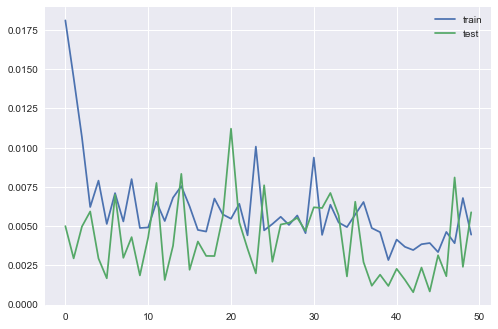

Test RMSE: 454.167


In [12]:
values = c1.values
# ensure all data is float
values = values.astype('float64')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[15:], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 150 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#invert scaling for forecast
inv_yhat =concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

## Minute_Modelling for C2

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000483        0.0   0.000113   0.980848   0.881776   0.514565   
2   0.000468        0.0   0.000112   0.984928   0.881670   0.513352   
3   0.000403        0.0   0.000043   0.986020   0.883591   0.509017   
4   0.000409        0.0   0.000033   0.987471   0.886039   0.503533   
5   0.000445        0.0   0.000078   0.991557   0.886246   0.500191   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.553574        0.0        0.0    0.484623    0.716065         0.0   
2   0.547581        0.0        0.0    0.481168    0.739676         0.0   
3   0.543170        0.0        0.0    0.476531    0.760682         0.0   
4   0.538106        0.0        0.0    0.488603    0.748687         0.0   
5   0.534077        0.0        0.0    0.497591    0.771003         0.0   

   var13(t-1)  var14(t-1)  var15(t-1)  
1    0.956522    0.966667         0.0  
2    1.000000    0.966667         0.0  
3    0.0

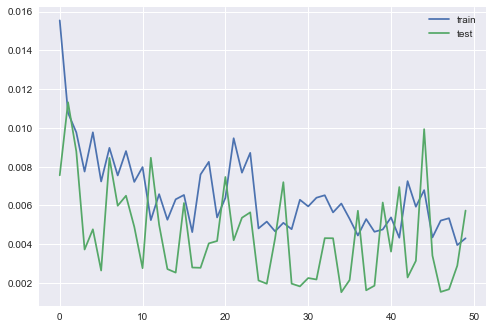

Test RMSE: 925.192


In [13]:
values2 = c2.values
# ensure all data is float
values2 = values2.astype('float64')
# normalize features
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaled2 = scaler2.fit_transform(values2)
# frame as supervised learning
reframed2 = series_to_supervised(scaled2, 1, 1)
# drop columns we don't want to predict
reframed2.drop(reframed2.columns[15:], axis=1, inplace=True)
print(reframed2.head())

# split into train and test sets
values2 = reframed2.values
n_train_hours2 = 150* 24
train2 = values2[:n_train_hours2, :]
test2 = values2[n_train_hours2:, :]
# split into input and outputs
train_X2, train_y2 = train2[:, :-1], train2[:, -1]
test_X2, test_y2 = test2[:, :-1], test2[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X2 = train_X2.reshape((train_X2.shape[0], 1, train_X2.shape[1]))
test_X2 = test_X2.reshape((test_X2.shape[0], 1, test_X2.shape[1]))
print(train_X2.shape, train_y2.shape, test_X2.shape, test_y2.shape)

# design network
model2 = Sequential()
model2.add(LSTM(50, input_shape=(train_X2.shape[1], train_X2.shape[2])))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
# fit network
history = model2.fit(train_X2, train_y2, epochs=50, batch_size=72, validation_data=(test_X2, test_y2), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


# make a prediction
yhat2 = model.predict(test_X2)
test_X2 = test_X2.reshape((test_X2.shape[0], test_X2.shape[2]))
#invert scaling for forecast
inv_yhat2 =concatenate((yhat2, test_X2), axis=1)
inv_yhat2 = scaler2.inverse_transform(inv_yhat2)
inv_yhat2 = inv_yhat2[:,0]

# invert scaling for actual
test_y2 = test_y2.reshape((len(test_y2), 1))
inv_y2 = concatenate((test_y2, test_X2), axis=1)
inv_y2 = scaler2.inverse_transform(inv_y2)
inv_y2 = inv_y2[:,0]
# calculate RMSE
rmse2 = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Test RMSE: %.3f' % rmse2)

In [14]:
len(c3)

1678

## Minute_Modelling for C3

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.298151   0.310218   0.300687   0.643541   0.814275   0.645069   
2   0.518026   0.529365   0.510155   0.226301   0.305666   0.684810   
3   0.209275   0.204694   0.202258   0.272869   0.275045   0.576947   
4   0.046609   0.046129   0.044262   0.377890   0.356427   0.562913   
5   0.415005   0.428545   0.415848   1.000000   0.952864   0.661724   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.726164   0.345157   0.111608    0.505889    0.868211         0.0   
2   0.709599   0.901526   0.333507    0.474169    0.889446         0.0   
3   0.659196   0.508501   0.189215    0.452484    0.911261         0.0   
4   0.690123   0.167990   0.050079    0.428680    0.945241         0.0   
5   0.723101   0.915234   0.199249    0.641247    0.643271         0.0   

   var13(t-1)  var14(t-1)  var15(t-1)  
1    0.565217    0.066667    0.054385  
2    0.608696    0.066667    0.030911  
3    0.6

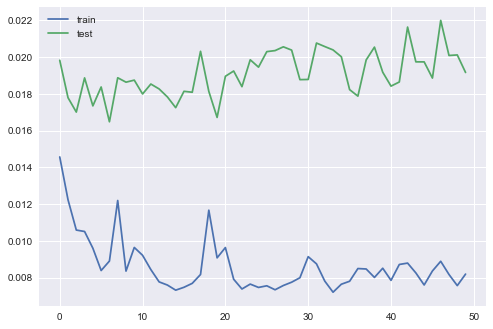

Test RMSE: 3783.354


In [18]:
values3 = c3.values
# ensure all data is float
values3 = values3.astype('float64')
# normalize features
scaler3 = MinMaxScaler(feature_range=(0, 1))
scaled3 = scaler3.fit_transform(values3)
# frame as supervised learning
reframed3 = series_to_supervised(scaled3, 1, 1)
# drop columns we don't want to predict
reframed3.drop(reframed3.columns[15:], axis=1, inplace=True)
print(reframed3.head())

# split into train and test sets
values3 = reframed3.values
n_train_hours3 = 55 * 24
train3 = values3[:n_train_hours3, :]
test3 = values3[n_train_hours3:, :]
# split into input and outputs
train_X3, train_y3 = train3[:, :-1], train3[:, -1]
test_X3, test_y3 = test3[:, :-1], test3[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X3 = train_X3.reshape((train_X3.shape[0], 1, train_X3.shape[1]))
test_X3 = test_X3.reshape((test_X3.shape[0], 1, test_X3.shape[1]))
print(train_X3.shape, train_y3.shape, test_X3.shape, test_y3.shape)

# design network
model3 = Sequential()
model3.add(LSTM(50, input_shape=(train_X3.shape[1], train_X3.shape[2])))
model3.add(Dense(1))
model3.compile(loss='mae', optimizer='adam')
# fit network
history = model3.fit(train_X3, train_y3, epochs=50, batch_size=72, validation_data=(test_X3, test_y3), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


# make a prediction
yhat3 = model.predict(test_X3)
test_X3 = test_X3.reshape((test_X3.shape[0], test_X3.shape[2]))
#invert scaling for forecast
inv_yhat3 =concatenate((yhat3, test_X3), axis=1)
inv_yhat3 = scaler3.inverse_transform(inv_yhat3)
inv_yhat3 = inv_yhat3[:,0]

# invert scaling for actual
test_y3 = test_y3.reshape((len(test_y3), 1))
inv_y3 = concatenate((test_y3, test_X3), axis=1)
inv_y3= scaler3.inverse_transform(inv_y3)
inv_y3= inv_y3[:,0]
# calculate RMSE
rmse3 = sqrt(mean_squared_error(inv_y3, inv_yhat3))
print('Test RMSE: %.3f' % rmse3)

## Minute_Modelling for C4

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.338627   0.356033   0.359625   1.000000   1.000000   0.587444   
2   0.946779   0.982860   1.000000   0.336469   0.492475   0.852345   
3   0.844372   0.868163   0.886787   0.193959   0.341544   0.808142   
4   0.763551   0.795931   0.810120   0.182667   0.317781   0.792559   
5   0.744979   0.769546   0.788280   0.175354   0.305589   0.810570   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.622458   0.372105   0.237938    0.450706    0.897533         0.0   
2   0.775732   0.954668   0.540726    0.471263    0.841007         0.0   
3   0.756236   0.949116   0.539114    0.472935    0.827174         0.0   
4   0.746665   0.950826   0.537385    0.507512    0.753843         0.0   
5   0.772356   0.947794   0.539976    0.567206    0.665436         0.0   

   var13(t-1)  var14(t-1)  var15(t-1)  
1    0.304348         1.0    0.014639  
2    0.347826         1.0    0.015277  
3    0.3

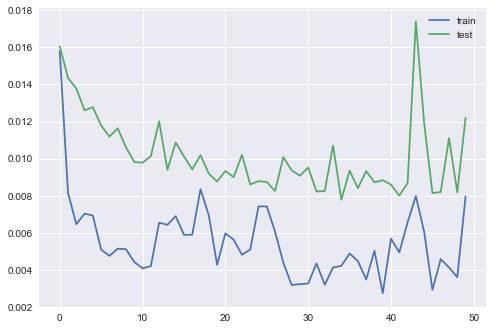

Test RMSE: 3569.585


In [20]:
values4 = c4.values
# ensure all data is float
values4 = values4.astype('float64')
# normalize features
scaler4 = MinMaxScaler(feature_range=(0, 1))
scaled4 = scaler4.fit_transform(values4)
# frame as supervised learning
reframed4 = series_to_supervised(scaled4, 1, 1)
# drop columns we don't want to predict
reframed4.drop(reframed4.columns[15:], axis=1, inplace=True)
print(reframed4.head())

# split into train and test sets
values4 = reframed4.values
n_train_hours4 = 70 * 24
train4 = values4[:n_train_hours4, :]
test4 = values4[n_train_hours4:, :]
# split into input and outputs
train_X4, train_y4 = train4[:, :-1], train4[:, -1]
test_X4, test_y4 = test4[:, :-1], test4[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X4 = train_X4.reshape((train_X4.shape[0], 1, train_X4.shape[1]))
test_X4 = test_X4.reshape((test_X4.shape[0], 1, test_X4.shape[1]))
print(train_X4.shape, train_y4.shape, test_X4.shape, test_y4.shape)

# design network
model4 = Sequential()
model4.add(LSTM(50, input_shape=(train_X4.shape[1], train_X4.shape[2])))
model4.add(Dense(1))
model4.compile(loss='mae', optimizer='adam')
# fit network
history = model4.fit(train_X4, train_y4, epochs=50, batch_size=72, validation_data=(test_X4, test_y4), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat4 = model.predict(test_X4)

test_X4 = test_X4.reshape((test_X4.shape[0], test_X4.shape[2]))

#invert scaling for forecast
inv_yhat4 =concatenate((yhat4, test_X4), axis=1)
inv_yhat4 = scaler4.inverse_transform(inv_yhat4)
inv_yhat4 = inv_yhat4[:,0]


# invert scaling for actual
test_y4 = test_y4.reshape((len(test_y4), 1))
inv_y4 = concatenate((test_y4, test_X4), axis=1)
inv_y4 = scaler4.inverse_transform(inv_y4)
inv_y4 = inv_y4[:,0]
# calculate RMSE
rmse4 = sqrt(mean_squared_error(inv_y4, inv_yhat4))
print('Test RMSE: %.3f' % rmse4)